In [3]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d_pcsaft import dft_core
from cdft.pcsaft_eos import pcsaft

device = torch.device('cuda')

In [4]:
m = torch.tensor([1.0, 1.6069], dtype=torch.float64)
sigma = torch.tensor([3.7039, 3.5206], dtype=torch.float64)
epsilon = torch.tensor([150.03, 191.42], dtype=torch.float64)
parameters = {'m':m, 'sigma':sigma, 'epsilon':epsilon}

In [5]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.12/site-packages/pymatgen/core/structure.py:3107: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  struct = parser.parse_structures(primitive=primitive)[0]


In [6]:
T = 300.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters, T, system_size, points, device)

In [7]:
forcefield = pd.DataFrame()
forcefield['type'] = ['Zn','H','C','O']
forcefield['sigma'] = np.array([4.045, 2.846, 3.47299, 3.033])
forcefield['epsilon'] = np.array([27.677, 7.6489, 47.8562, 48.1581])
forcefield['mass'] = np.array([65.38, 1.00784, 12.0107, 15.999])

def lj_potential(r,sigma,epsilon):
    return 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 

Vext = torch.zeros((dft.Nc, points[0], points[1], points[2]),device=device,dtype=torch.float64)
U = torch.zeros_like(dft.X)
rc = 12.0
for i in range(dft.Nc):
    for k, site in enumerate(structure):
        sigmasf = float(0.5*(sigma[i].numpy()+forcefield['sigma'][forcefield['type']==site.species_string]))
        epsilonsf = float(np.sqrt(epsilon[i].numpy()*forcefield['epsilon'][forcefield['type']==site.species_string]))
        rx = dft.X-structure.cart_coords[k,0] 
        ry = dft.Y-structure.cart_coords[k,1] 
        rz = dft.Z-structure.cart_coords[k,2] 
        rx -= system_size[0]*(rx/system_size[0]).round()
        ry -= system_size[1]*(ry/system_size[1]).round()
        rz -= system_size[2]*(rz/system_size[2]).round()
        r = torch.sqrt(rx**2+ry**2+rz**2)
        U = m[i]*lj_potential(r,sigmasf,epsilonsf)
        U[r==0] = np.inf
        U[r>rc] = 0.0
        Vext[i] += U

/tmp/ipykernel_29084/2051356827.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma[i].numpy()+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_29084/2051356827.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilonsf = float(np.sqrt(epsilon[i].numpy()*forcefield['epsilon'][forcefield['type']==site.species_string]))


Text(0, 0.5, '$y$ (\\AA{})')

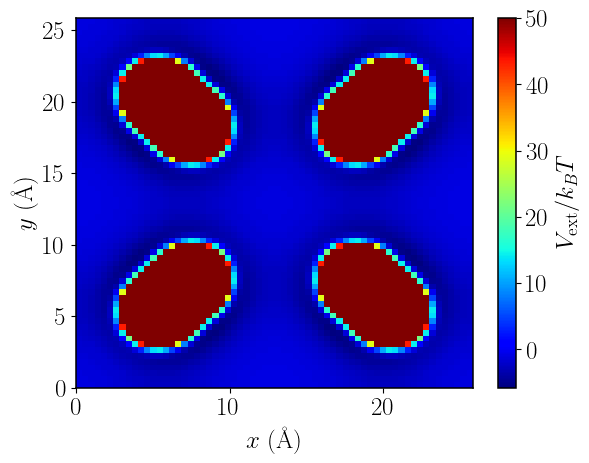

In [8]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),Vext[1,:,:,points[2]//2].cpu()/T, vmax=50.0, cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [9]:
P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))

bulk_density = torch.empty_like(P)
composition = torch.tensor([0.4,0.6],dtype=torch.float64)

eos = pcsaft(parameters, T)
bulk_density[0] = eos.density(P[0],composition,'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],composition,bulk_density[i-1])

/tmp/ipykernel_29084/516255902.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))


In [10]:
dft.initial_condition(bulk_density[0],composition,Vext)

/media/lucas/HD/GitHub/LJS-cDFT/cdft/dft3d_pcsaft.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Vext = tensor(Vext/self.T,device=self.device,dtype=float64)


In [11]:
Nads = torch.empty((dft.Nc,len(P)),dtype=torch.float64)
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],composition,fmt='ASWB',solver='anderson',
                                    anderson_mmax=10,anderson_damping=0.2,tol=1e-6,logoutput=False)
    for j in range(dft.Nc):
        Nads[j,i] = dft.total_molecules[j]
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[:,i].numpy())
    if np.isnan(dft.error.numpy()): break

14 7.835342148183939e-07 1.0 [1.19327233 9.25846464]
14 3.5112599450180336e-07 2.0 [ 2.56924532 23.19429321]
15 1.393103185057714e-07 3.0000000000000004 [ 3.83522049 38.55332513]
15 3.67640040897117e-07 4.0 [ 4.80455802 51.42611675]
14 9.1694529391861e-07 5.0 [ 5.50500356 60.71956079]
14 8.856726811902392e-07 6.000000000000001 [ 6.03830673 67.33255643]
14 8.332445534905077e-07 7.000000000000001 [ 6.47239457 72.21707523]
15 5.698683156309626e-07 8.0 [ 6.84369213 75.97341458]
16 7.348372288349626e-07 9.0 [ 7.17232499 78.96146652]
17 3.418810239191757e-07 10.0 [ 7.47022055 81.40347306]
23 8.773385759666841e-07 20.0 [ 9.69311216 93.26380773]
25 4.2686730328722545e-07 30.000000000000004 [11.43130976 97.54214217]
24 7.712967882425806e-07 40.0 [13.07438496 99.4429551 ]
25 9.275965751119704e-07 50.00000000000001 [ 14.78163479 100.11071749]
25 9.889290303817423e-07 60.00000000000001 [16.6789953  99.92092622]
25 9.580012021537709e-07 70.0 [18.87488979 99.02100201]
24 9.341542025642769e-07 80.0 [

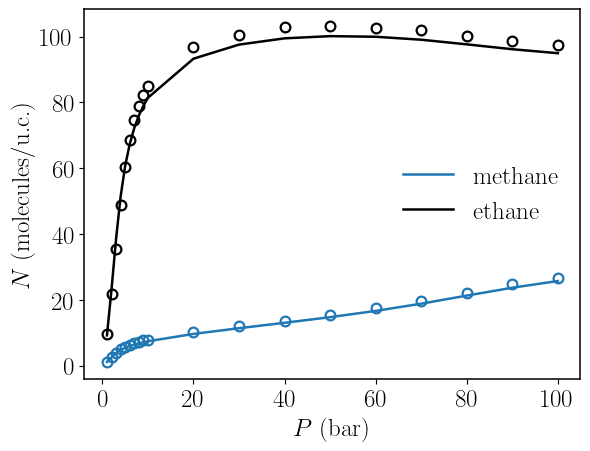

In [12]:
data = pd.read_pickle('data/isotherm_methane_ethane.pkl')

plt.plot(P*1e-5, Nads[0], 'C0-', linewidth=1.8, label='methane')
plt.plot(P*1e-5, Nads[1], 'k-', linewidth=1.8, label='ethane')
plt.plot(data['pressure'], data['methane'], 'C0o', markersize=7, markeredgewidth=1.6, mfc = 'none')
plt.plot(data['pressure'], data['ethane'], 'ko', markersize=7, markeredgewidth=1.6, mfc = 'none')
plt.xlabel(r'$P$ (bar)')
plt.ylabel(r'$N$ (molecules/u.c.)')
plt.legend()
# plt.savefig('figures/isotherm_co2.png', bbox_inches='tight')